In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import lime 
from lime import lime_tabular

import shap

In [2]:
df = pd.read_csv("bank-full.csv",sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


The dataset was taken from UCI Machine Learning Repository which is a source for publicly available datasets. It consists of 45211 data points with 17 independent variables out of which 7 are numeric features and 10 are categorical features. 

In [3]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [4]:
df.duplicated

<bound method DataFrame.duplicated of        age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         cont

In [5]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There is no missing feilds in the dataset.

<AxesSubplot:xlabel='marital', ylabel='count'>

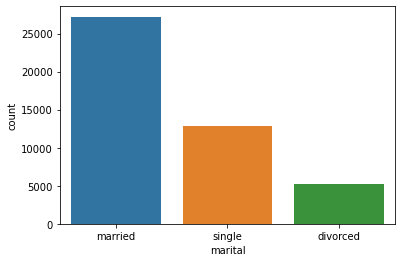

In [8]:
sns.countplot(data = df,x = 'marital')

Most of applicasts are Married and single.

<AxesSubplot:xlabel='education', ylabel='count'>

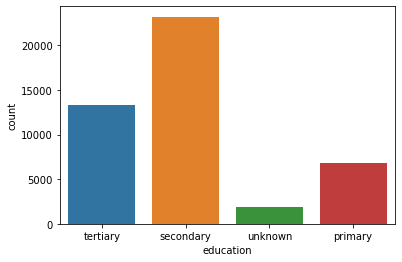

In [9]:
sns.countplot(data = df,x = 'education')

Most of applicants have gained secondary and teritary education. 

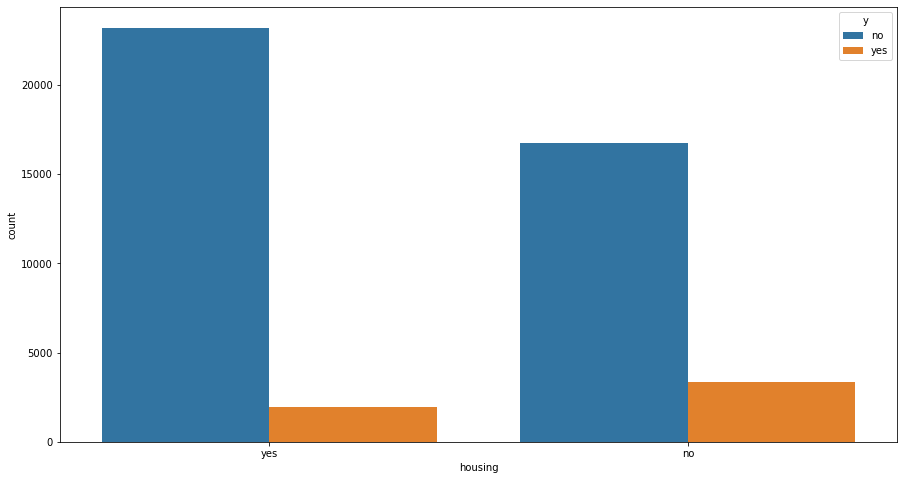

In [10]:
sns.countplot(data = df,x = 'housing', hue = "y")
plt.gcf().set_size_inches(15, 8)

As we can see from the above plot, majority of the customers have a housing loan. However this feature might be important for the model as approximatley equal applicants are subscribed currently having a home loan. 

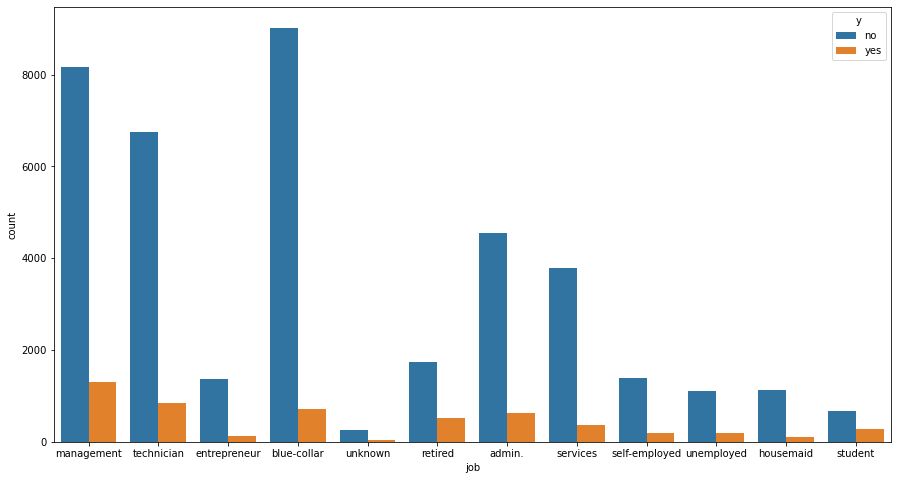

In [11]:
sns.countplot(data = df,x = 'job', hue = "y")
plt.gcf().set_size_inches(15, 8)

From the above plot, we can see that the customers who have a job of management have the highest rate of subscribing a term deposit, while most of blue collar and management employees are not subscribing.

In [12]:

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

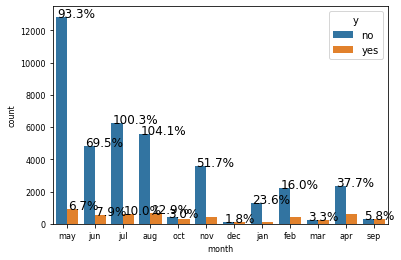

In [13]:
ax = sns.countplot(data = df,x = 'month', hue = "y")
plt.xticks(size = 8)
plt.xlabel('month', size =8)
plt.yticks(size=8)
plt.ylabel('count', size = 8)

with_hue(ax, df.month,4,4)

All the months have the different distribution for both the classes. Above 50% of the customers on any given month refuse to subscribe to a term deposit, and 1.8–10% of customers agrees to subscribe. This might helpful in predicting the target variable.


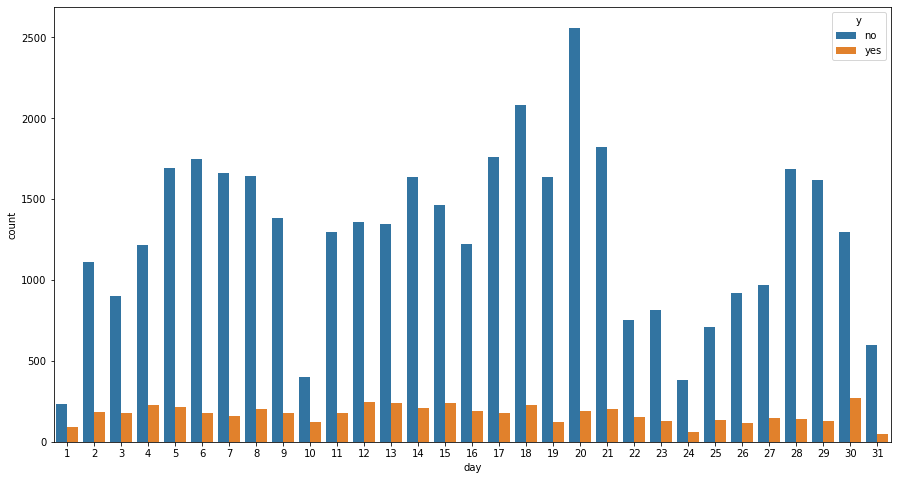

In [14]:
sns.countplot(data = df,x = 'day', hue = "y")
plt.gcf().set_size_inches(15, 8)

In general, all the days have the similar distribution for both the classes. With this we can deduce that this feature will not be very helpful in predicting the target variable.

<AxesSubplot:xlabel='y', ylabel='age'>

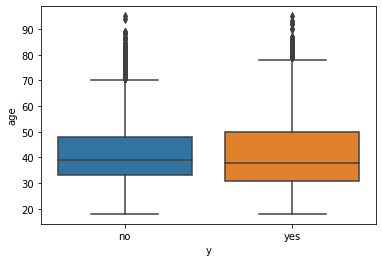

In [15]:
sns.boxplot(data=df, x='y',y='age')

Median age of around 38–40 for both subscribed or unsubscribed

<Figure size 720x576 with 0 Axes>

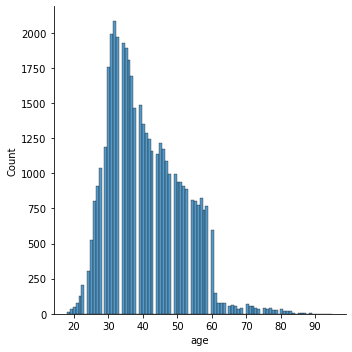

In [16]:
plt.figure(figsize=(10,8))
sns.displot(df['age'])

Due to the distribution of the age count, it might be intresting to analyze further in the model.  

<Figure size 720x576 with 0 Axes>

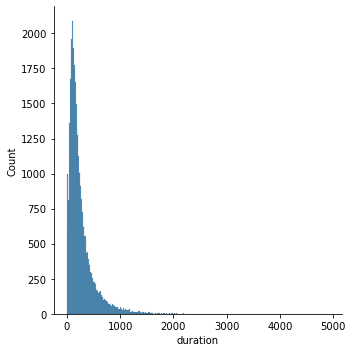

In [17]:
plt.figure(figsize=(10,8))
sns.displot(df['duration'])

From the above plot it is clear that, the duration (last contact duration) of a customer can be useful for predicting the target variable.

<Figure size 720x576 with 0 Axes>

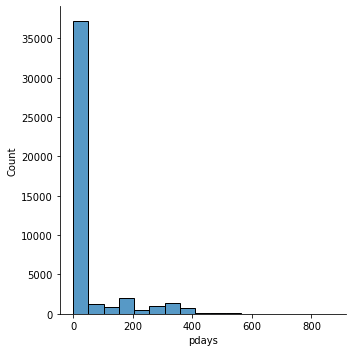

In [18]:
plt.figure(figsize=(10,8))
sns.displot(df['pdays'])

pdays feature is very interesting in our case study. It denotes the number of days that passed by after the client was last contacted from a previous campaign.

<Figure size 720x576 with 0 Axes>

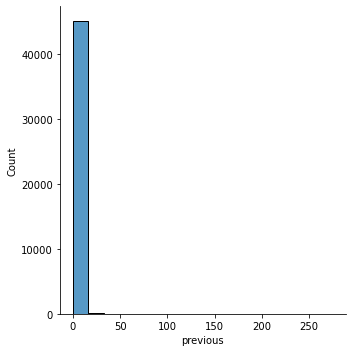

In [19]:
plt.figure(figsize=(10,8))
sns.displot(df['previous'])

It's seems to be there is a correlation between pday and previous. Further will be analysed in the heat map. 

In [20]:
df.age

0        58
1        44
2        33
3        47
4        33
         ..
45206    51
45207    71
45208    72
45209    57
45210    37
Name: age, Length: 45211, dtype: int64

Text(0.5, 1.05, 'Pearson correlation of Features')

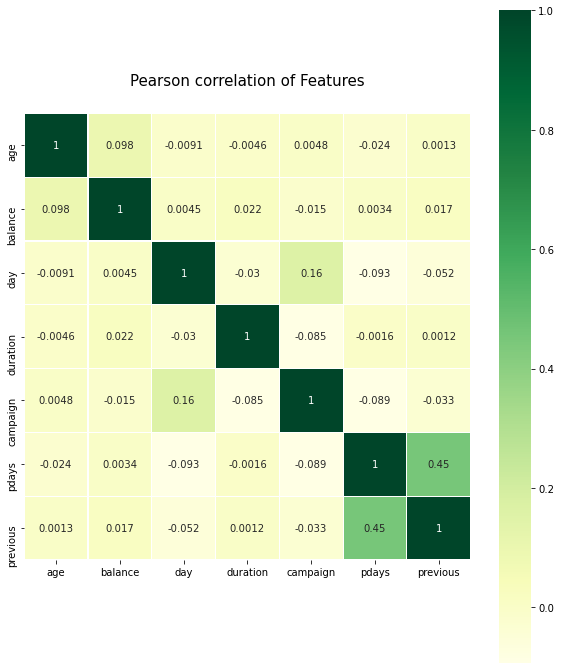

In [21]:
corr = df.corr()

f, ax = plt.subplots(figsize=(10,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)




We can select either pdays or previous for model as both features correlated. 

<AxesSubplot:xlabel='y', ylabel='count'>

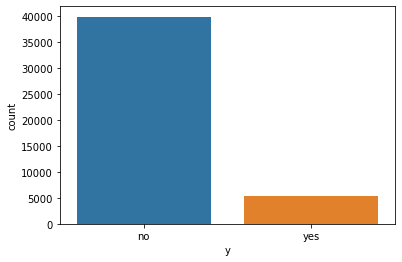

In [22]:
sns.countplot(data = df,x = 'y')

Finally, selected dataset shows highly imbalanced classification, which people who are subscribed to term deposit doesn’t have enough examples. Therefore we need to use different techniques and perspectives to combat Imbalance data.

The followings are two different techniques for resampling:
Upsampling (increase your minority class)
Downsampling (decrease your majority class)


In [23]:
from sklearn.utils import resample
df_majority = df.loc[df['y']=="yes"]
df_minority = df.loc[df['y']=='no']



In [24]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=2000)

In [25]:
#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=2000)

In [26]:
# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority_upsampled])

In [27]:
X = df[['age', 'balance', 'campaign','duration','pdays']]

y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [29]:
model.classes_

array(['no', 'yes'], dtype=object)

In [30]:
y_pred = model.predict(X_test)

In [31]:
test_result = pd.DataFrame(data={'y_act':y_test, 'y_pred':y_pred, 'y_pred_prob_A':model.predict_proba(X_test)[:, 0], 'y_pred_prob_B':model.predict_proba(X_test)[:, 1]})
test_result.head(10)

,y_act,y_pred,y_pred_prob_A,y_pred_prob_B
40683,yes,yes,0.094,0.906
6995,no,no,0.904,0.096
33963,yes,yes,0.288,0.712
30213,no,no,0.930,0.070
28046,no,no,0.944,0.056
39597,yes,yes,0.162,0.838
17455,yes,yes,0.122,0.878
25322,yes,no,0.705,0.295
23610,yes,yes,0.056,0.944
42132,yes,yes,0.111,0.889


In [32]:
cfm = pd.crosstab(test_result['y_act'], test_result['y_pred'], margins=True)
cfm

y_pred,no,yes,All
y_act,,,
no,460,118,578
yes,137,485,622
All,597,603,1200


In [33]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 0]

In [34]:
test_result = pd.DataFrame(data={'y_act':y_test=='no', 'y_pred':y_pred=='no', 'y_pred_prob':y_pred_prob})
test_result.head(10)

,y_act,y_pred,y_pred_prob
40683,False,False,0.094
6995,True,True,0.904
33963,False,False,0.288
30213,True,True,0.930
28046,True,True,0.944
39597,False,False,0.162
17455,False,False,0.122
25322,False,True,0.705
23610,False,False,0.056
42132,False,False,0.111


In [35]:
test_result[['y_act', 'y_pred']] = test_result[['y_act', 'y_pred']].astype('int')
test_result

,y_act,y_pred,y_pred_prob
40683,0,0,0.094
6995,1,1,0.904
33963,0,0,0.288
30213,1,1,0.930
28046,1,1,0.944
...,...,...,...
25924,1,1,0.953
39358,0,0,0.454
30905,0,0,0.129
25845,0,0,0.059


In [36]:
cfm = pd.crosstab(test_result['y_act'], test_result['y_pred'], margins=True)
cfm

y_pred,0,1,All
y_act,,,
0,485,137,622
1,118,460,578
All,603,597,1200


In [37]:
acuracy_rf = metrics.accuracy_score(test_result['y_act'], test_result['y_pred']) 
acuracy_rf

0.7875

In [38]:
precision_rf = metrics.precision_score(test_result['y_act'], test_result['y_pred'], average='binary', pos_label=0)
precision_rf

0.8043117744610282

In [39]:
f1_score_rf = metrics.f1_score(test_result['y_act'], test_result['y_pred'], average='weighted')  #weighted accounts for label imbalance.
f1_score_rf

0.7875701259227096

In [40]:
roc_auc_rf = metrics.roc_auc_score(test_result['y_act'], test_result['y_pred_prob'])
roc_auc_rf

0.8669488979628168

In [41]:
test_result['q_bucket'] = pd.qcut(test_result['y_pred_prob'], q=10, duplicates='drop')
test_result['q_bucket']

calib_table  = test_result.groupby(by='q_bucket').agg(
    count=pd.NamedAgg(column="q_bucket", aggfunc="count"),
    response_count=pd.NamedAgg(column="y_act", aggfunc="sum"),
    min_probability = pd.NamedAgg(column="y_pred_prob", aggfunc="min"),
    mean_probability = pd.NamedAgg(column="y_pred_prob", aggfunc="mean"),
    ).reset_index()

calib_table['precision'] = calib_table['response_count'] / calib_table['count'] 
calib_table['response_fraction'] = calib_table['response_count'] / calib_table['response_count'].sum()
calib_table

,q_bucket,count,response_count,min_probability,mean_probability,precision,response_fraction
0,"(0.009999999999999998, 0.0789]",120,6,0.011,0.050858,0.050000,0.010381
1,"(0.0789, 0.144]",120,15,0.079,0.109667,0.125000,0.025952
2,"(0.144, 0.214]",120,15,0.144,0.177608,0.125000,0.025952
3,"(0.214, 0.339]",121,37,0.214,0.274124,0.305785,0.064014
4,"(0.339, 0.498]",119,45,0.340,0.426630,0.378151,0.077855
5,"(0.498, 0.656]",120,55,0.499,0.574475,0.458333,0.095156
6,"(0.656, 0.806]",120,83,0.657,0.728967,0.691667,0.143599
7,"(0.806, 0.914]",121,103,0.807,0.868893,0.851240,0.178201
8,"(0.914, 0.966]",122,107,0.915,0.942787,0.877049,0.185121
9,"(0.966, 1.0]",117,112,0.968,0.985231,0.957265,0.193772


<AxesSubplot:xlabel='mean_probability'>

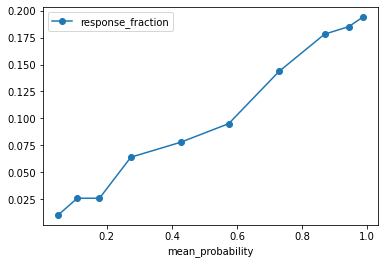

In [42]:
calib_table.plot(x='mean_probability', y='response_fraction', marker='o')

In [43]:
feature_importances = model.feature_importances_
feature_importances

array([0.17230083, 0.18994901, 0.05922206, 0.46897953, 0.10954858])

<AxesSubplot:xlabel='mean_probability'>

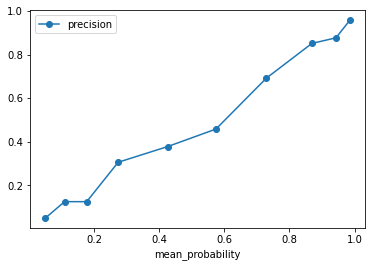

In [44]:
calib_table.plot(x='mean_probability', y='precision', marker='o')

In [45]:
X_test

,age,balance,campaign,duration,pdays
40683,67,405,2,345,-1
6995,54,192,3,157,-1
33963,59,493,1,237,-1
30213,38,1819,3,101,-1
28046,26,2020,3,42,-1
...,...,...,...,...,...
25924,34,5057,1,73,-1
39358,28,0,5,390,-1
30905,33,700,1,126,88
25845,46,3354,1,522,174


In [46]:
features = X_test.columns
features

Index(['age', 'balance', 'campaign', 'duration', 'pdays'], dtype='object')

In [47]:
feature_importance_table = pd.DataFrame(data={'features': features, 'feature_importances':feature_importances})
feature_importance_table

,features,feature_importances
0,age,0.172301
1,balance,0.189949
2,campaign,0.059222
3,duration,0.468980
4,pdays,0.109549


In [48]:
feature_importance_table.sort_values(by='feature_importances', ascending=False)

,features,feature_importances
3,duration,0.468980
1,balance,0.189949
0,age,0.172301
4,pdays,0.109549
2,campaign,0.059222


Decision Tree Classifer 

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
model = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split=20)

# Train Model
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=0)

In [51]:
# Predict on Testing Data

# probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Prediction
y_pred = model.predict(X_test)

# Results table
test_result = pd.DataFrame(data={'y_act':y_test, 'y_pred':y_pred, 'y_pred_prob':y_pred_prob})
test_result.sample(5)

,y_act,y_pred,y_pred_prob
15097,no,no,0.235294
7195,no,no,0.063492
42290,yes,yes,0.818182
18625,yes,yes,0.896552
11510,yes,yes,0.976190


In [52]:
cfm = pd.crosstab(test_result['y_act'], test_result['y_pred'], margins=True)
cfm

y_pred,no,yes,All
y_act,,,
no,443,135,578
yes,171,451,622
All,614,586,1200


In [53]:
acuracy_tc = metrics.accuracy_score(test_result['y_act'], test_result['y_pred']) 
acuracy_tc

0.745

In [54]:
precision_tc = metrics.precision_score(test_result['y_act'], test_result['y_pred'], average='binary', pos_label='yes')
precision_tc

0.7696245733788396

In [55]:
f1_score_tc = metrics.f1_score(test_result['y_act'], test_result['y_pred'], average='weighted')  #weighted accounts for label imbalance.
f1_score_tc

0.7450510022667675

In [56]:
roc_auc_tc = metrics.roc_auc_score(test_result['y_act'], test_result['y_pred_prob'])
roc_auc_tc

0.8246406279553623

Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
df['y_act'] = np.where(df['y']=='yes',1,0)

In [59]:
y_varibale = 'y_act'
df[y_varibale].head()

44346    1
31434    1
10416    1
33965    1
31329    1
Name: y_act, dtype: int64

In [60]:
y = df[y_varibale].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(F"Train sample size = {len(X_train)}")
print(F"Test sample size  = {len(X_test)}")

Train sample size = 2800
Test sample size  = 1200


In [62]:
model = LogisticRegression()

# Train Model
model.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [63]:
model.predict_proba(X_test)[:5]

array([[0.5273169 , 0.4726831 ],
       [0.75121754, 0.24878246],
       [0.58885611, 0.41114389],
       [0.7839293 , 0.2160707 ],
       [0.8234622 , 0.1765378 ]])

In [64]:
df[['y', 'y_act']].value_counts()

y    y_act
no   0        2000
yes  1        2000
dtype: int64

In [65]:
model.predict(X_test)[:5]

array([0, 0, 0, 0, 0])

In [66]:
# probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Prediction
y_pred = model.predict(X_test)

# Results table
test_result = pd.DataFrame(data={'y_act':y_test, 'y_pred':y_pred, 'y_pred_prob':y_pred_prob})
test_result.sample(5)

,y_act,y_pred,y_pred_prob
690,1,0,0.279916
1142,0,1,0.838290
955,0,0,0.279340
487,0,0,0.368828
1067,0,0,0.404050


In [67]:
cfm = pd.crosstab(test_result['y_act'], test_result['y_pred'], margins=True)
cfm

y_pred,0,1,All
y_act,,,
0,476,102,578
1,229,393,622
All,705,495,1200


In [68]:
acuracy_lgr = metrics.accuracy_score(test_result['y_act'], test_result['y_pred']) 
acuracy_lgr

0.7241666666666666

In [69]:
precision_lgr = metrics.precision_score(test_result['y_act'], test_result['y_pred'], average='binary', pos_label=1)
precision_lgr

0.793939393939394

In [70]:
f1_score_lgr = metrics.f1_score(test_result['y_act'], test_result['y_pred'], average='weighted')  #weighted accounts for label imbalance.
f1_score_lgr

0.7221378223087161

In [71]:
roc_auc_lgr = metrics.roc_auc_score(test_result['y_act'], test_result['y_pred_prob'])
roc_auc_lgr

0.8227644944870326

Evaluation focuss will change Accuracy to Precision, Recall, F1 Score as data is imbalanced.  

In [72]:
metrics_comp = [['LGR', acuracy_lgr, precision_lgr, f1_score_lgr,roc_auc_lgr],
['TC', acuracy_tc, precision_tc, f1_score_tc,roc_auc_tc],
['RF', acuracy_rf, precision_rf, f1_score_rf,roc_auc_rf]]

pd.DataFrame(data=metrics_comp, columns=['Model', 'accuracy', 'precision', 'f1_score','ROC'])

,Model,accuracy,precision,f1_score,ROC
0,LGR,0.724167,0.793939,0.722138,0.822764
1,TC,0.745000,0.769625,0.745051,0.824641
2,RF,0.787500,0.804312,0.787570,0.866949


According to the comparison of  precision,f1_score and ROC Decision Random Forest model is highly perfoming in predict whether client will subscribe a term deposit.

Now we can build the model workflow while tunning the Random Forest classifer with feature enginerring and parameter tunning.

Data Academy Capstone Project - Dhanushka Abeyratne